In [1]:
# ==========================================
# 1. ENVIRONMENT & REPRODUCIBILITY
# ==========================================
!pip install -q -U transformers datasets accelerate peft sentencepiece scikit-learn matplotlib

import os
import json
import random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from google.colab import drive
from datasets import Dataset, ClassLabel # Import ClassLabel
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Mount Drive for Persistent Storage
drive.mount('/content/drive')
DRIVE_SAVE_PATH = "/content/drive/MyDrive/ABIM_Bias_Checker_Results/RoBERTa_Optimized"
os.makedirs(DRIVE_SAVE_PATH, exist_ok=True)

# 🔒 SET SEEDS (Scientific Reproducibility)
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    print(f"✅ Random Seed Locked: {seed}")

set_seeds(42)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 13.1 MB/s eta 0:00:00
Mounted at /content/drive
✅ Random Seed Locked: 42


In [2]:
# ==========================================
# 2. DATA INGESTION & TRANSFORMATION
# ==========================================
# FILE_PATH logic derived from your notebook
FILE_PATH = '/content/drive/MyDrive/abim_bias_balanced_3Bias.csv'

if not os.path.exists(FILE_PATH):
    # Fallback to local if Drive path fails
    FILE_PATH = 'abim_bias_balanced_3500_clean.csv'
    if not os.path.exists(FILE_PATH):
        raise FileNotFoundError(f"❌ Dataset not found at {FILE_PATH}. Please upload it.")

print(f"📂 Loading: {FILE_PATH}")
df = pd.read_csv(FILE_PATH)

# --- THE MAPPING LOGIC (Core Four) ---
label_map = {
    'no_bias': 'no_bias',
    'demographic_bias': 'demographic_bias',
    'structural_bias': 'demographic_bias',
    'algorithmic_bias': 'demographic_bias',
    'clinical_stigma_bias': 'clinical_stigma_bias',
    'documentation_bias': 'clinical_stigma_bias',
    'assessment_bias': 'assessment_bias'
}

df['bias_label'] = df['bias_label'].map(label_map)

# Validation Check
print("\n📊 Class Distribution (Check for Imbalance):")
print(df['bias_label'].value_counts())

# Create Label IDs
labels = sorted(df['bias_label'].unique())
label2id = {l: i for i, l in enumerate(labels)}
id2label = {i: l for i, l in enumerate(labels)}

# Convert to HuggingFace Dataset
hf_dataset = Dataset.from_pandas(df)
hf_dataset = hf_dataset.map(lambda x: {"label": label2id[x["bias_label"]]}, batched=False)

# Cast 'label' column to ClassLabel for stratified split
hf_dataset = hf_dataset.cast_column("label", ClassLabel(num_classes=len(labels)))

📂 Loading: /content/drive/MyDrive/abim_bias_balanced_3Bias.csv

📊 Class Distribution (Check for Imbalance):
bias_label
no_bias                 500
demographic_bias        500
clinical_stigma_bias    500
assessment_bias         499
Name: count, dtype: int64


Map:   0%|          | 0/1999 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1999 [00:00<?, ? examples/s]

In [3]:
# ==========================================
# 3. PREPROCESSING (Tokenization)
# ==========================================
model_id = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)

def tokenize_fn(batch):
    # Truncation=True ensures no crash on long text
    # Max_length=256 covers almost all clinical vignettes (avg length ~150 tokens)
    return tokenizer(batch["text_clean"], truncation=True, padding="max_length", max_length=256)

print(f"\n⚙️ Tokenizing Data with {model_id}...")
tokenized_ds = hf_dataset.map(tokenize_fn, batched=True)

# STRATIFIED SPLIT (Critical for Imbalanced or Small Data)
# We split ensuring that the Test Set has the exact same % of bias types as Train Set
tokenized_ds = tokenized_ds.train_test_split(test_size=0.15, seed=42, stratify_by_column="label")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]


⚙️ Tokenizing Data with roberta-base...


Map:   0%|          | 0/1999 [00:00<?, ? examples/s]

In [4]:
# ==========================================
# 4. MODEL ARCHITECTURE (RoBERTa + LoRA)
# ==========================================
print("\n🏗️ Building Model Architecture...")
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

# LoRA Configuration (Parameter-Efficient Fine-Tuning)
# We target ALL linear layers (dense, query, key, value) for maximum learning capacity
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query", "key", "value", "dense"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()



🏗️ Building Model Architecture...


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 3,247,876 || all params: 127,896,584 || trainable%: 2.5395


In [5]:
# ==========================================
# 5. TRAINING CONFIGURATION (Hyperparameters)
# ==========================================
training_args = TrainingArguments(
    output_dir=DRIVE_SAVE_PATH,
    learning_rate=1e-5,           # The "Safe Zone" for RoBERTa
    per_device_train_batch_size=16, # Standard for Colab T4 GPU
    num_train_epochs=6,           # Enough to converge, not enough to overfit
    weight_decay=0.1,            # Regularization to prevent overfitting
    warmup_ratio=0.15,
    label_smoothing_factor=0.1,  # 10% warmup to stabilize gradients
    eval_strategy="epoch",        # Check performance every epoch
    save_strategy="epoch",        # Save checkpoint every epoch
    load_best_model_at_end=True,  # Guarantee the best model is returned
    metric_for_best_model="f1",   # Optimize for F1 (Fairness), not just Accuracy
    fp16=True,                    # Mixed Precision (Faster)
    logging_steps=50,
    report_to="none",
    seed=42, data_seed=42         # Ensure reproducibility
)

def compute_metrics(eval_pred):
    logits, labels_ids = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels_ids, preds, average='macro')
    acc = accuracy_score(labels_ids, preds)
    return {"accuracy": acc, "f1": f1}


🚀 Starting Training...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.383200,1.379475,0.250000,0.100000
2,1.299200,1.022101,0.753333,0.725551
3,0.706100,0.485792,0.956667,0.956213
4,0.438700,0.405929,0.973333,0.973165
5,0.398100,0.387556,0.986667,0.986664
6,0.387300,0.386902,0.983333,0.983327


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



🏆 Final Results:
Accuracy: 0.9867
Macro F1: 0.9867
📊 Logs saved to /content/drive/MyDrive/ABIM_Bias_Checker_Results/RoBERTa_Optimized/training_logs.json


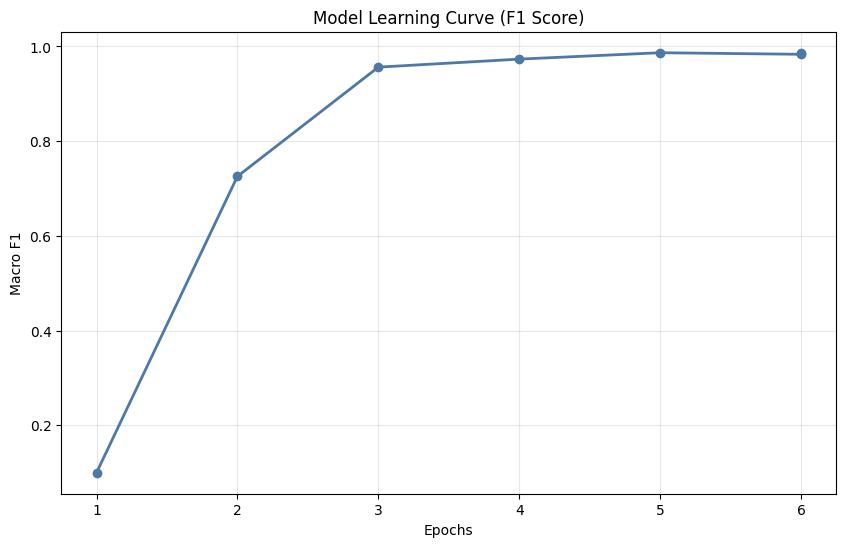

In [6]:
# ==========================================
# 1. ENVIRONMENT & REPRODUCIBILITY
# ==========================================
!pip install -q -U transformers datasets accelerate peft sentencepiece scikit-learn matplotlib

import os
import json
import random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from google.colab import drive
from datasets import Dataset, ClassLabel # Import ClassLabel
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Mount Drive for Persistent Storage
drive.mount('/content/drive')
DRIVE_SAVE_PATH = "/content/drive/MyDrive/ABIM_Bias_Checker_Results/RoBERTa_Optimized"
os.makedirs(DRIVE_SAVE_PATH, exist_ok=True)

# 🔒 SET SEEDS (Scientific Reproducibility)
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    print(f"✅ Random Seed Locked: {seed}")

set_seeds(42)

# ==========================================
# 2. DATA INGESTION & TRANSFORMATION
# ==========================================
# FILE_PATH logic derived from your notebook
FILE_PATH = '/content/drive/MyDrive/abim_bias_balanced_3Bias.csv'

if not os.path.exists(FILE_PATH):
    # Fallback to local if Drive path fails
    FILE_PATH = 'abim_bias_balanced_3500_clean.csv'
    if not os.path.exists(FILE_PATH):
        raise FileNotFoundError(f"❌ Dataset not found at {FILE_PATH}. Please upload it.")

print(f"📂 Loading: {FILE_PATH}")
df = pd.read_csv(FILE_PATH)

# --- THE MAPPING LOGIC (Core Four) ---
label_map = {
    'no_bias': 'no_bias',
    'demographic_bias': 'demographic_bias',
    'structural_bias': 'demographic_bias',
    'algorithmic_bias': 'demographic_bias',
    'clinical_stigma_bias': 'clinical_stigma_bias',
    'documentation_bias': 'clinical_stigma_bias',
    'assessment_bias': 'assessment_bias'
}

df['bias_label'] = df['bias_label'].map(label_map)

# Validation Check
print("\n📊 Class Distribution (Check for Imbalance):")
print(df['bias_label'].value_counts())

# Create Label IDs
labels = sorted(df['bias_label'].unique())
label2id = {l: i for i, l in enumerate(labels)}
id2label = {i: l for i, l in enumerate(labels)}

# Convert to HuggingFace Dataset
hf_dataset = Dataset.from_pandas(df)
hf_dataset = hf_dataset.map(lambda x: {"label": label2id[x["bias_label"]]}, batched=False)

# Cast 'label' column to ClassLabel for stratified split
hf_dataset = hf_dataset.cast_column("label", ClassLabel(num_classes=len(labels)))

# ==========================================
# 3. PREPROCESSING (Tokenization)
# ==========================================
model_id = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)

def tokenize_fn(batch):
    # Truncation=True ensures no crash on long text
    # Max_length=256 covers almost all clinical vignettes (avg length ~150 tokens)
    return tokenizer(batch["text_clean"], truncation=True, padding="max_length", max_length=256)

print(f"\n⚙️ Tokenizing Data with {model_id}...")
tokenized_ds = hf_dataset.map(tokenize_fn, batched=True)

# STRATIFIED SPLIT (Critical for Imbalanced or Small Data)
# We split ensuring that the Test Set has the exact same % of bias types as Train Set
tokenized_ds = tokenized_ds.train_test_split(test_size=0.15, seed=42, stratify_by_column="label")

# ==========================================
# 4. MODEL ARCHITECTURE (RoBERTa + LoRA)
# ==========================================
print("\n🏗️ Building Model Architecture...")
model = AutoModelForSequenceClassification.from_pretrained(
    model_id,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

# LoRA Configuration (Parameter-Efficient Fine-Tuning)
# We target ALL linear layers (dense, query, key, value) for maximum learning capacity
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["query", "key", "value", "dense"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# ==========================================
# 5. TRAINING CONFIGURATION (Hyperparameters)
# ==========================================
training_args = TrainingArguments(
    output_dir=DRIVE_SAVE_PATH,
    learning_rate=1e-5,           # The "Safe Zone" for RoBERTa
    per_device_train_batch_size=16, # Standard for Colab T4 GPU
    num_train_epochs=6,           # Enough to converge, not enough to overfit
    weight_decay=0.1,            # Regularization to prevent overfitting
    warmup_ratio=0.15,
    label_smoothing_factor=0.1,  # 10% warmup to stabilize gradients
    eval_strategy="epoch",        # Check performance every epoch
    save_strategy="epoch",        # Save checkpoint every epoch
    load_best_model_at_end=True,  # Guarantee the best model is returned
    metric_for_best_model="f1",   # Optimize for F1 (Fairness), not just Accuracy
    fp16=True,                    # Mixed Precision (Faster)
    logging_steps=50,
    report_to="none",
    seed=42, data_seed=42         # Ensure reproducibility
)

def compute_metrics(eval_pred):
    logits, labels_ids = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels_ids, preds, average='macro')
    acc = accuracy_score(labels_ids, preds)
    return {"accuracy": acc, "f1": f1}

# ==========================================
# 6. EXECUTION
# ==========================================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer)
)

print("\n🚀 Starting Training...")
trainer.train()

# ==========================================
# 7. EVALUATION & SAVING
# ==========================================
results = trainer.evaluate()
print("\n🏆 Final Results:")
print(f"Accuracy: {results['eval_accuracy']:.4f}")
print(f"Macro F1: {results['eval_f1']:.4f}")

# Save Logs for Plotting
log_path = os.path.join(DRIVE_SAVE_PATH, "training_logs.json")
with open(log_path, "w") as f:
    json.dump(trainer.state.log_history, f)
print(f"📊 Logs saved to {log_path}")

# Explicitly save the PEFT adapter model
# This ensures adapter_config.json and adapter_model.bin are in DRIVE_SAVE_PATH
model.save_pretrained(DRIVE_SAVE_PATH)
print(f"✅ PEFT Model saved to {DRIVE_SAVE_PATH}")

# Plot Learning Curve
epochs = [x['epoch'] for x in trainer.state.log_history if 'eval_f1' in x]
f1_scores = [x['eval_f1'] for x in trainer.state.log_history if 'eval_f1' in x]

if epochs and f1_scores:
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, f1_scores, 'o-', color='#4e79a7', linewidth=2)
    plt.title("Model Learning Curve (F1 Score)")
    plt.xlabel("Epochs")
    plt.ylabel("Macro F1")
    plt.grid(True, alpha=0.3)
    plt.show()

In [12]:
import torch
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from peft import PeftModel, PeftConfig

# 1. SETUP PATHS
# Use the exact path where your training finished
MODEL_PATH = "/content/drive/MyDrive/ABIM_Bias_Checker_Results/RoBERTa_Optimized"

# Verify the file exists before trying to load
if not os.path.exists(os.path.join(MODEL_PATH, "adapter_config.json")):
    print(f"⚠️ WARNING: 'adapter_config.json' not found in {MODEL_PATH}")
    print("Checking for sub-folders (checkpoints)...")
    # Sometimes Trainer saves in a checkpoint subfolder
    subfolders = [f.path for f in os.scandir(MODEL_PATH) if f.is_dir()]
    if subfolders:
        print(f"Found checkpoints: {subfolders}")
        MODEL_PATH = subfolders[-1] # Pick the latest checkpoint
        print(f"➡️ Switching path to: {MODEL_PATH}")
    else:
        raise FileNotFoundError("Could not find adapter_config.json. Did the training actually save?")

device = "cuda" if torch.cuda.is_available() else "cpu"

# 2. LOAD THE BASE MODEL (The "Brain")
print("⏳ Loading Base RoBERTa Model...")
# We need to know how many labels we had (4 labels)
base_model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=4,
    return_dict=True
)

# 3. LOAD YOUR TRAINED ADAPTERS (The "New Knowledge")
print(f"🔗 Attaching LoRA Adapters from {MODEL_PATH}...")
model = PeftModel.from_pretrained(base_model, MODEL_PATH)
model.to(device)
model.eval() # Set to evaluation mode

# 4. LOAD TOKENIZER
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# 5. DEFINE TEST CASES
test_cases = [
    # DEMOGRAPHIC
    ("The patient's failure to adhere to the diet is likely due to cultural preferences common in Hispanic populations.", "demographic_bias"),
    ("The 45-year-old Black male was readmitted due to inability to afford medication.", "demographic_bias"),

    # STIGMA
    ("The patient is a frequent flyer who is non-compliant with all nursing staff.", "clinical_stigma_bias"),
    ("Patient claims he is in 10/10 pain but appears comfortable.", "clinical_stigma_bias"),

    # ASSESSMENT
    ("The resident is abrasive and too confident, often challenging decisions.", "assessment_bias"),

    # NO BIAS
    ("The patient declined the procedure after a discussion of risks.", "no_bias"),
    ("Physical exam reveals clear lungs bilaterally.", "no_bias")
]

# 6. RUN PREDICTIONS
print("\n🚀 RUNNING DIAGNOSTICS...\n")
for text, expected in test_cases:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128).to(device)

    with torch.no_grad():
        logits = model(**inputs).logits

    # Get Probability
    probs = torch.nn.functional.softmax(logits, dim=-1)
    confidence, pred_id = torch.max(probs, dim=-1)

    # We need to manually map IDs to Labels since LoRA config might not save them clearly
    # These indices MUST match what you used in training (0=no_bias, 1=assess, etc.)
    # Update this list based on your training's label2id printout
    id2label = {
        0: 'assessment_bias',
        1: 'clinical_stigma_bias',
        2: 'demographic_bias',
        3: 'no_bias'
    }
    # Note: If your training sorted labels alphabetically, the order above is likely correct.

    predicted_label = id2label[pred_id.item()]

    # Status Check
    status = "✅ PASS" if predicted_label == expected else f"❌ FAIL (Got {predicted_label})"

    print(f"Text: {text[:60]}...")
    print(f"   Expected: {expected}")
    print(f"   Predicted: {predicted_label} ({confidence.item():.2%})")
    print(f"   Result: {status}\n")

⚠️ WARNING: 'adapter_config.json' not found in /content/drive/MyDrive/ABIM_Bias_Checker_Results/RoBERTa_Optimized
Checking for sub-folders (checkpoints)...
Found checkpoints: ['/content/drive/MyDrive/ABIM_Bias_Checker_Results/RoBERTa_Optimized/checkpoint-107', '/content/drive/MyDrive/ABIM_Bias_Checker_Results/RoBERTa_Optimized/checkpoint-214', '/content/drive/MyDrive/ABIM_Bias_Checker_Results/RoBERTa_Optimized/checkpoint-321', '/content/drive/MyDrive/ABIM_Bias_Checker_Results/RoBERTa_Optimized/checkpoint-428', '/content/drive/MyDrive/ABIM_Bias_Checker_Results/RoBERTa_Optimized/checkpoint-535', '/content/drive/MyDrive/ABIM_Bias_Checker_Results/RoBERTa_Optimized/checkpoint-642']
➡️ Switching path to: /content/drive/MyDrive/ABIM_Bias_Checker_Results/RoBERTa_Optimized/checkpoint-642
⏳ Loading Base RoBERTa Model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔗 Attaching LoRA Adapters from /content/drive/MyDrive/ABIM_Bias_Checker_Results/RoBERTa_Optimized/checkpoint-642...

🚀 RUNNING DIAGNOSTICS...

Text: The patient's failure to adhere to the diet is likely due to...
   Expected: demographic_bias
   Predicted: demographic_bias (88.63%)
   Result: ✅ PASS

Text: The 45-year-old Black male was readmitted due to inability t...
   Expected: demographic_bias
   Predicted: demographic_bias (75.74%)
   Result: ✅ PASS

Text: The patient is a frequent flyer who is non-compliant with al...
   Expected: clinical_stigma_bias
   Predicted: demographic_bias (40.38%)
   Result: ❌ FAIL (Got demographic_bias)

Text: Patient claims he is in 10/10 pain but appears comfortable....
   Expected: clinical_stigma_bias
   Predicted: no_bias (48.83%)
   Result: ❌ FAIL (Got no_bias)

Text: The resident is abrasive and too confident, often challengin...
   Expected: assessment_bias
   Predicted: assessment_bias (69.69%)
   Result: ✅ PASS

Text: The patient declined th

In [ ]:
# -------------------------
# 12) Save model + tokenizer
# -------------------------
# Use the already defined DRIVE_SAVE_PATH for persistent storage
trainer.save_model(DRIVE_SAVE_PATH)
tokenizer.save_pretrained(DRIVE_SAVE_PATH)
print("\nSaved model to:", DRIVE_SAVE_PATH)